In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, spearmanr

In [2]:
df = pd.read_csv('data/ready_df_with_dep.csv')
df.head()

,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,DepDelay,DepDel15,DepTimeBlk,...,dep_time_shift_sin,dep_time_shift_cos,is_night_departure,is_evening_departure,low_visibility,strong_wind,wind_gust,bad_weather_score,is_hub_route,is_roundtrip
0,1,1,1,1,AA,SDF,MIA,0.0,0.0,0001-0559,...,0.000000,0.000000,0,0,0,0,0,0,0,1
1,1,1,1,1,NK,SDF,LAS,-7.0,0.0,0600-0659,...,-0.000466,0.030539,0,0,0,0,0,0,0,1
2,1,1,1,1,DL,SDF,ATL,-4.0,0.0,0600-0659,...,-0.000152,0.017452,0,0,0,0,0,0,1,1
3,1,1,1,1,WN,SDF,MCO,-4.0,0.0,0600-0659,...,0.000228,0.017452,0,0,0,0,0,0,0,1
4,1,1,1,1,AA,SDF,CLT,18.0,1.0,0600-0659,...,-0.009229,-0.077975,0,0,0,0,0,0,1,1


In [3]:
df.shape

(47518, 59)

In [4]:
num_features = [
    # new features
    "dep_delay_ratio",
    "bad_weather_score",
    "dep_time_shift_sin",
    "dep_time_shift_cos",
    
    # delay and time
    "DepDelay",
    "TaxiOut",
    "CRSElapsedTime",

    # distance
    "Distance",
    "DistanceGroup",

    # weather
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyPrecipitation",
    "HourlyRelativeHumidity",
    "HourlySeaLevelPressure",
    "HourlyVisibility",
    "HourlyWindGustSpeed",
    "HourlyWindSpeed",

    # wind (encoded)
    "wind_dir_sin",
    "wind_dir_cos",

    # cyclic time (sin / cos)
    "WheelsOff_sin",
    "WheelsOff_cos",
    "CRSArrTime_sin",
    "CRSArrTime_cos",
    "CRSDepTime_sin",
    "CRSDepTime_cos",
    "DepTime_sin",
    "DepTime_cos",
]
cat_features = [
    # calendar
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",

    # airport
    "Reporting_Airline",
    "Origin",
    "Dest",

    # time blocks
    "DepTimeBlk",

    # weather (categories)
    "HourlyWeatherType",
    "HourlySkyCondit",
]
pass_features = [
    # new binary
    "dep_delay_gt30",
    "dep_delay_gt60",
    "taxiout_long",
    "is_night_departure",
    "is_evening_departure",
    "low_visibility",
    "strong_wind",
    "wind_gust",
    "is_hub_route",
    "is_roundtrip",
    
    # binaries
    "wind_dir_vrb",
    "DepDel15"
]

target_feature = ['ArrDel15']

In [5]:
len(num_features + cat_features + pass_features)

49

# EDA

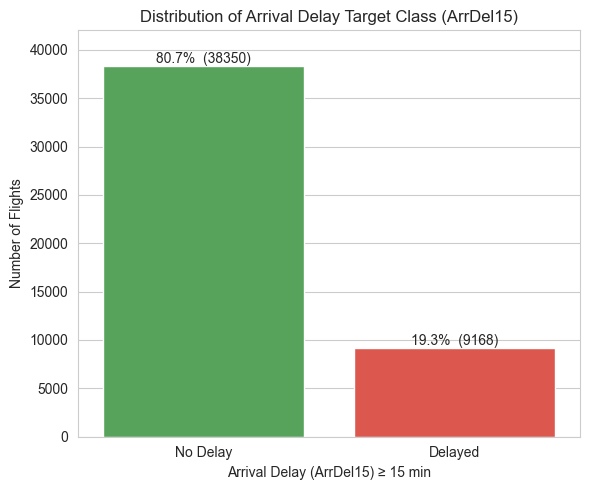

In [7]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(
    data=df,
    x="ArrDel15",
    hue="ArrDel15",
    palette={0: "#4CAF50", 1: "#F44336"},
    legend=False
)

# Annotations with percent
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    ax.annotate(
        f"{percent:.1f}%  ({count})",
        (p.get_x() + p.get_width() / 2, count),
        ha="center",
        va="bottom"
    )

plt.xlabel("Arrival Delay (ArrDel15) ≥ 15 min")
plt.ylabel("Number of Flights")
plt.title("Distribution of Arrival Delay Target Class (ArrDel15)")

plt.xticks([0, 1], ["No Delay", "Delayed"])
plt.ylim([0, 42000])

plt.tight_layout()
plt.savefig("img/EDA/ArrDel15_dist.png", dpi=300, bbox_inches='tight')
plt.show()

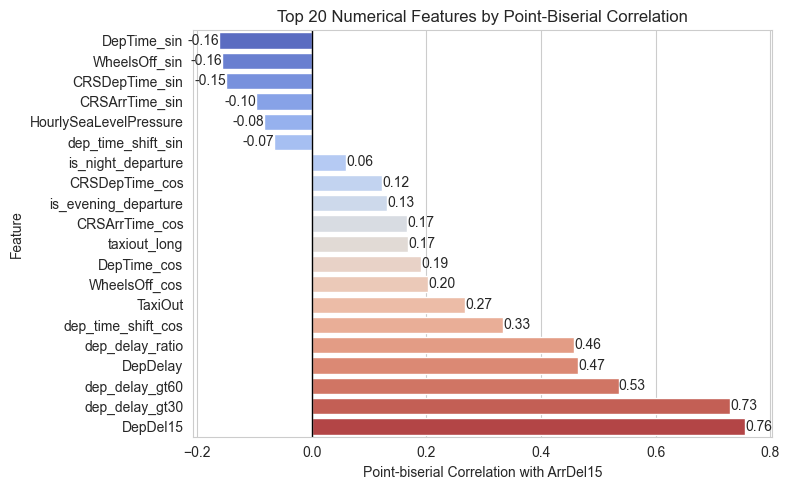

,feature,r,abs_r,p_value
25,DepTime_sin,-0.161113,0.161113,9.770188e-274
19,WheelsOff_sin,-0.157127,0.157127,2.694352e-260
23,CRSDepTime_sin,-0.148828,0.148828,1.907280e-233
21,CRSArrTime_sin,-0.097307,0.097307,2.584730e-100
13,HourlySeaLevelPressure,-0.083072,0.083072,1.555718e-73
2,dep_time_shift_sin,-0.065555,0.065555,2.031947e-46
30,is_night_departure,0.059767,0.059767,7.272715e-39
24,CRSDepTime_cos,0.123132,0.123132,6.898524e-160
31,is_evening_departure,0.131543,0.131543,2.213025e-182
22,CRSArrTime_cos,0.165983,0.165983,1.234714e-290


In [8]:
target = "ArrDel15"
TOP_N = 20  

results = []

for col in num_features + pass_features:
    valid = df[[col, target]].dropna()
    r, p = pointbiserialr(valid[target], valid[col])

    results.append({
        "feature": col,
        "r": r,
        "abs_r": abs(r),
        "p_value": p
    })

pb_df = pd.DataFrame(results)

top_pb = (
    pb_df
    .sort_values("abs_r", ascending=False)
    .head(TOP_N)
    .sort_values("r") 
)

plt.figure(figsize=(8, 5))

ax = sns.barplot(
    data=top_pb,
    x="r",
    y="feature",
    hue="feature",        
    palette="coolwarm",
    legend=False
)

plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Point-biserial Correlation with ArrDel15")
plt.ylabel("Feature")
plt.title(f"Top {TOP_N} Numerical Features by Point-Biserial Correlation")

# Annotations
for i, row in top_pb.iterrows():
    ax.text(
        row["r"],
        list(top_pb.index).index(i),
        f"{row['r']:.2f}",
        va="center",
        ha="left" if row["r"] > 0 else "right"
    )

plt.tight_layout()
plt.savefig(
    f"img/EDA/top_{TOP_N}_point_biserial.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

top_pb

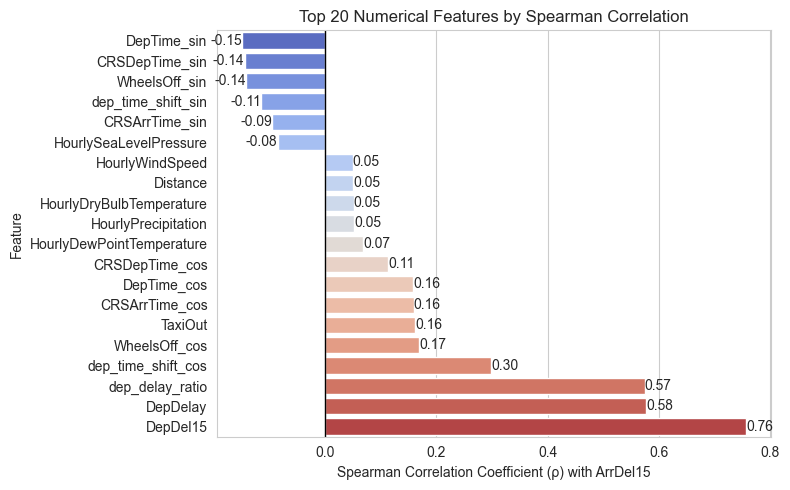

,feature,rho,abs_rho,p_value
25,DepTime_sin,-0.147923,0.147923,1.312282e-230
23,CRSDepTime_sin,-0.144231,0.144231,3.155544e-219
19,WheelsOff_sin,-0.142039,0.142039,1.310397e-212
2,dep_time_shift_sin,-0.114660,0.114660,9.018031e-139
21,CRSArrTime_sin,-0.094719,0.094719,3.968107e-95
13,HourlySeaLevelPressure,-0.084845,0.084845,1.227282e-76
16,HourlyWindSpeed,0.049904,0.049904,1.360054e-27
7,Distance,0.050378,0.050378,4.348583e-28
10,HourlyDryBulbTemperature,0.052008,0.052008,7.905758e-30
11,HourlyPrecipitation,0.052113,0.052113,6.085290e-30


In [9]:
target = "ArrDel15"
TOP_N = 20

results = []

for col in num_features + ["wind_dir_vrb", "DepDel15"]:
    valid = df[[col, target]].dropna()

    r, p = spearmanr(valid[col], valid[target]) 
    
    if pd.isna(r):
        continue

    results.append({
        "feature": col,
        "rho": r,
        "abs_rho": abs(r),
        "p_value": p
    })

sp_df = pd.DataFrame(results)

top_sp = (
    sp_df
    .sort_values("abs_rho", ascending=False)
    .head(TOP_N)
    .sort_values("rho")
)

plt.figure(figsize=(8, 5))

ax = sns.barplot(
    data=top_sp,
    x="rho",
    y="feature",
    hue="feature", 
    palette="coolwarm",
    legend=False
)

plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Spearman Correlation Coefficient (ρ) with ArrDel15")
plt.ylabel("Feature")
plt.title(f"Top {TOP_N} Numerical Features by Spearman Correlation")

# Annotations
for idx, row in top_sp.reset_index(drop=True).iterrows():
    ax.text(
        row["rho"],
        idx,
        f"{row['rho']:.2f}",
        va="center",
        ha="left" if row["rho"] > 0 else "right"
    )

plt.tight_layout()
plt.savefig(f"img/EDA/top_{TOP_N}_spearman.png", dpi=300, bbox_inches="tight")
plt.show()

top_sp

In [10]:
#def plot_numeric_distributions(df, features, bins=50):
#    for col in features:
#        plt.figure(figsize=(5, 3))
#        sns.histplot(
#            df[col].dropna(),
#            bins=bins,
#            kde=True,
#            stat="density"
#        )
#        plt.title(col)
#        plt.tight_layout()
#        plt.show()

In [11]:
#plot_numeric_distributions(df, num_features)

In [20]:
import os

# t-SNE, PCA, Truncated SVD

In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time

# Load data
df = pd.read_csv('data/ready_df_with_dep.csv')

# Split features and target
X = df.drop(columns=['ArrDel15'])
y = df['ArrDel15']

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# ColumnTransformer: one-hot for categorical, standard scaler for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
    ]
)

# Apply transformation
X_scaled = preprocessor.fit_transform(X)

print(f"Original shape: {X.shape}, Transformed shape: {X_scaled.shape}")

Original shape: (47518, 58), Transformed shape: (47518, 170)


In [23]:
# t-SNE ---------------------------------------
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, 
                      random_state=42,
                      n_jobs=-1).fit_transform(X_scaled)
t1 = time.time()
print(f't-SNE took {round(t1 - t0, 4)} seconds')

# PCA  -----------------------------------------
t0 = time.time()
X_reduced_pca = PCA(n_components=2, 
                    random_state=42).fit_transform(X_scaled)
t1 = time.time()
print(f'PCA took {round(t1 - t0, 4)} seconds')

# Truncated SVD  -----------------------------------------
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, 
                             random_state=42).fit_transform(X_scaled)
t1 = time.time()
print(f'Truncated SVD took {round(t1 - t0, 4)} seconds')

t-SNE took 68.8433 seconds
PCA took 0.0394 seconds
Truncated SVD took 0.0988 seconds


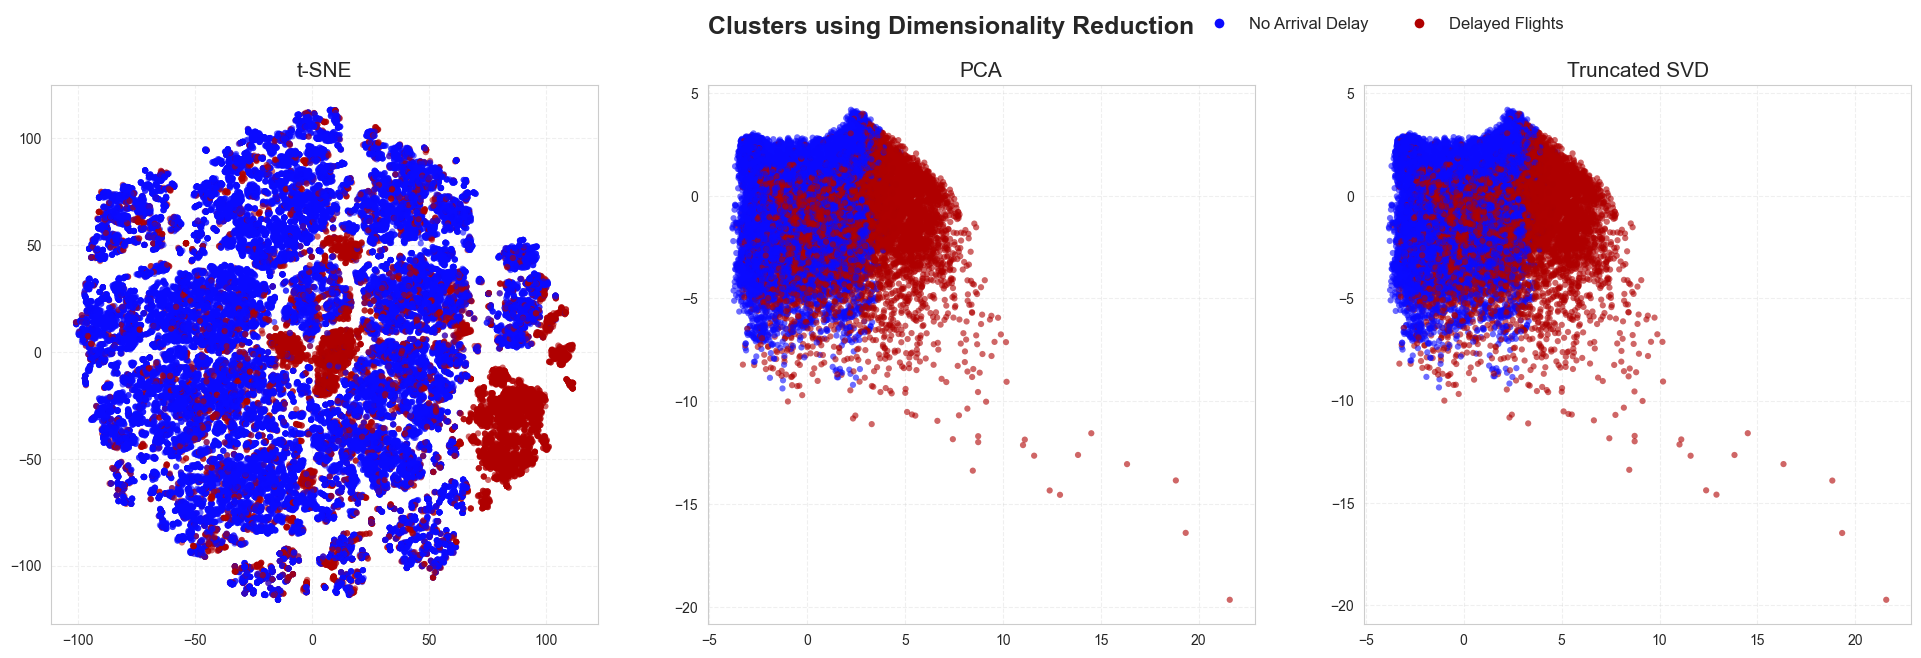

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Clusters using Dimensionality Reduction', fontsize=18, fontweight='bold')

# color mapping
colors = np.where(y == 0, '#0A0AFF', '#AF0000')

titles = ['t-SNE', 'PCA', 'Truncated SVD']
datasets = [X_reduced_tsne, X_reduced_pca, X_reduced_svd]

for ax, data, title in zip(axes, datasets, titles):
    ax.scatter(data[:, 0], 
               data[:, 1], 
               c=colors, 
               alpha=0.6,
               s=20,
               edgecolors='none')
    ax.set_title(title, fontsize=15)
    ax.grid(True, linestyle='--', alpha=0.3)

# Create clean legend once
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='No Arrival Delay',
           markerfacecolor='#0A0AFF', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Delayed Flights',
           markerfacecolor='#AF0000', markersize=8)
]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.68, 1),
    ncol=2,
    frameon=False,
    fontsize=12
)

plt.savefig("img/EDA/dim_reduction_clustering.png", dpi=300, bbox_inches="tight")
plt.show()

## Month

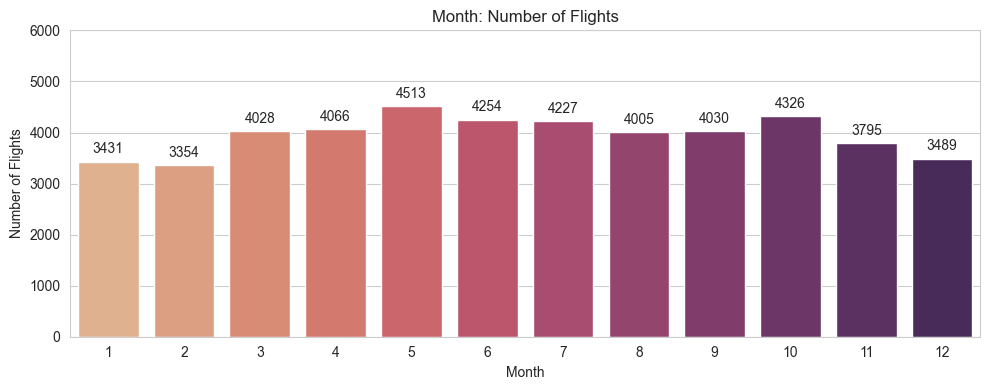

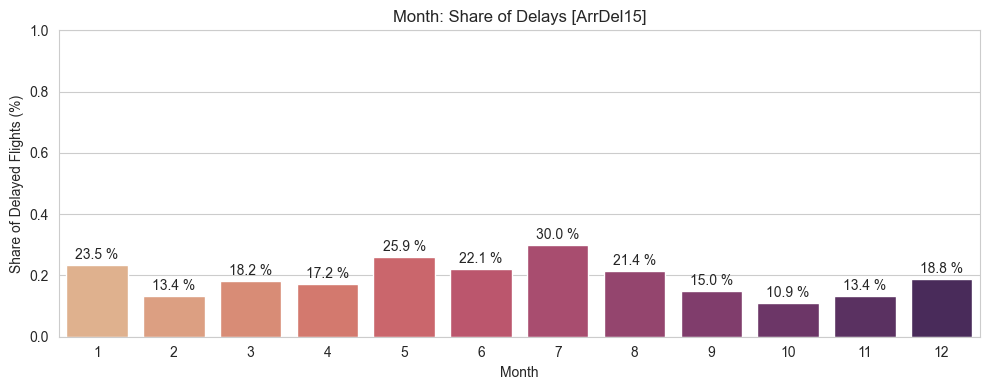

In [10]:
plt.figure(figsize=(10, 4))
month_palette = sns.color_palette("flare", as_cmap=True)
ax = sns.countplot(data=df, x='Month', order=range(1, 13), hue="Month", legend=False, palette=month_palette)
plt.title("Month: Number of Flights")
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.ylim([0, 6000])
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h:.0f}",
        xy=(p.get_x() + p.get_width() / 2, h+100),
        ha='center',
        va="bottom",
    )
plt.tight_layout()
plt.savefig("img/EDA/month_count.png", dpi=300, bbox_inches="tight")
plt.show()
#----------------------------------------------------------------------------
month_delay_rate = np.round(df.groupby("Month")['ArrDel15'].mean(), 3)
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=pd.DataFrame(month_delay_rate), x='Month', y='ArrDel15', order=range(1, 13), hue="Month", legend=False, palette=month_palette)
plt.title("Month: Share of Delays [ArrDel15]")
plt.xlabel('Month')
plt.ylabel("Share of Delayed Flights (%)")
plt.ylim([0, 1])
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h*100:.1f} %",
        xy=(p.get_x() + p.get_width() / 2, h+0.01),
        ha='center',
        va="bottom",
    )

plt.tight_layout()
plt.savefig("img/EDA/month_delay_rate.png", dpi=300, bbox_inches="tight")
plt.show()

## Day of Week

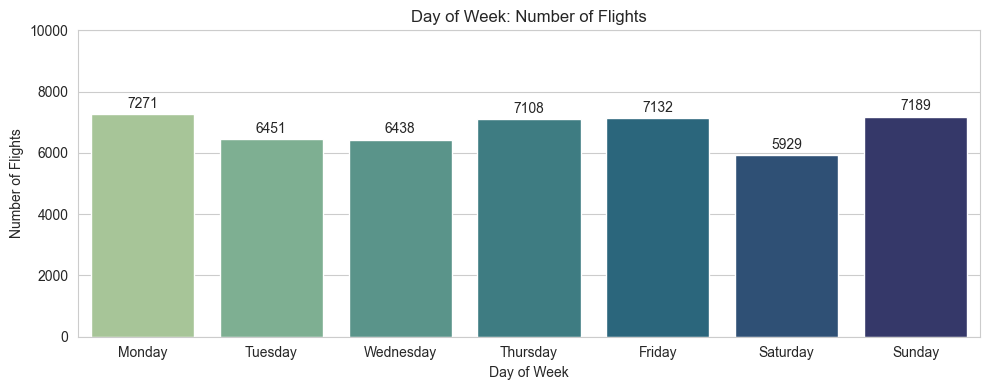

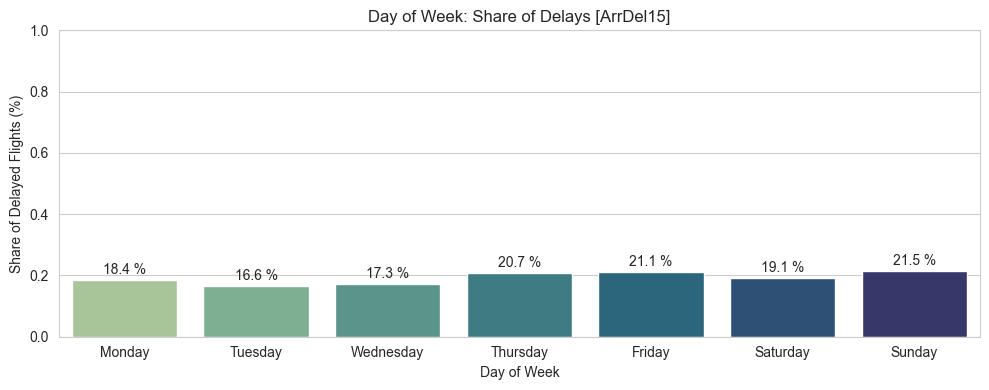

In [11]:
plt.figure(figsize=(10, 4))
DayOfWeek_palette = sns.color_palette("crest", as_cmap=True)
ax = sns.countplot(data=df, x="DayOfWeek", order=range(1, 8), hue="DayOfWeek", legend=False, palette=DayOfWeek_palette)
plt.title("Day of Week: Number of Flights")
plt.xlabel("Day of Week")
plt.xticks(
    range(0, 7),
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    rotation=0)
plt.ylabel("Number of Flights")
plt.ylim([0, 10000])
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h:.0f}",
        xy=(p.get_x() + p.get_width() / 2, h+100),
        ha='center',
        va="bottom",
    )
plt.tight_layout()
plt.savefig("img/EDA/DayOfWeek_count.png", dpi=300, bbox_inches="tight")
plt.show()
#----------------------------------------------------------------------------
DayOfWeek_delay_rate = np.round(df.groupby("DayOfWeek")['ArrDel15'].mean(), 3)
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=pd.DataFrame(DayOfWeek_delay_rate), x='DayOfWeek', y='ArrDel15', order=range(1, 8), hue="DayOfWeek", legend=False, palette=DayOfWeek_palette)
plt.title("Day of Week: Share of Delays [ArrDel15]")
plt.xlabel("Day of Week")
plt.xticks(
    range(0, 7),
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    rotation=0)
plt.ylabel("Share of Delayed Flights (%)")
plt.ylim([0, 1])
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h*100:.1f} %",
        xy=(p.get_x() + p.get_width() / 2, h+0.01),
        ha='center',
        va="bottom",
    )

plt.tight_layout()
plt.savefig("img/EDA/DayOfWeek_delay_rate.png", dpi=300, bbox_inches="tight")
plt.show()

## Airlines

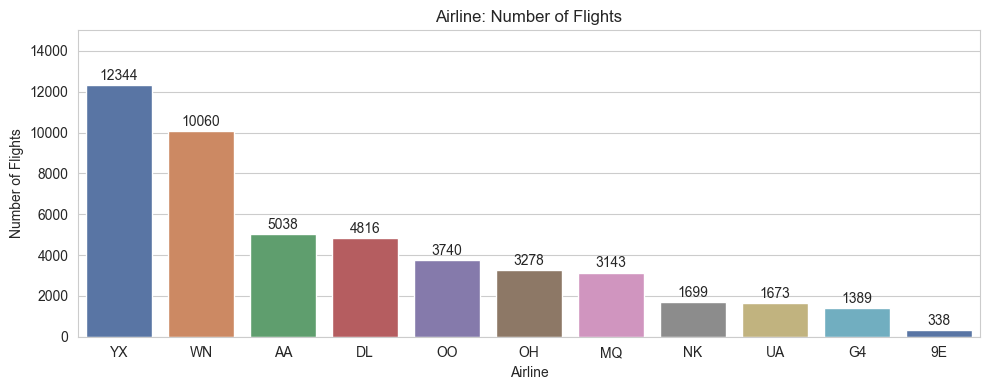

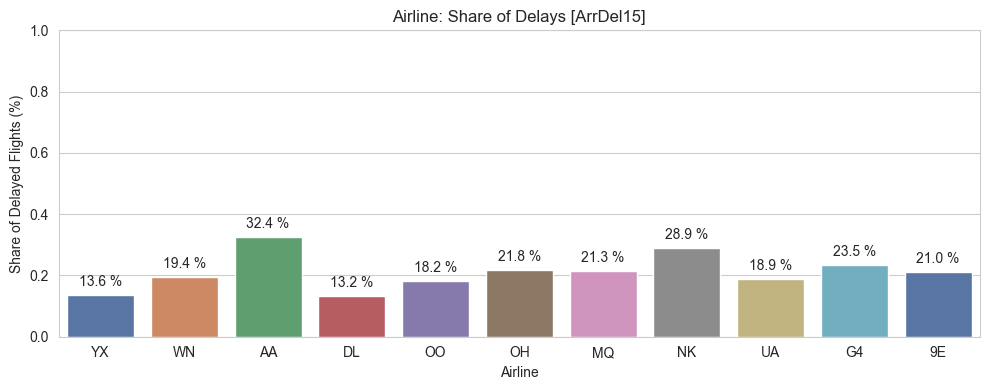

In [12]:
order = df['Reporting_Airline'].value_counts().index
colors = sns.color_palette("deep", n_colors=len(order))
palette_map = dict(zip(order, colors))

plt.figure(figsize=(10, 4))

ax = sns.countplot(data=df, x="Reporting_Airline", order=order, hue='Reporting_Airline', legend=False, palette=palette_map)
plt.title("Airline: Number of Flights")
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.ylim([0, 15000])
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h:.0f}",
        xy=(p.get_x() + p.get_width() / 2, h+100),
        ha='center',
        va="bottom",
    )
plt.tight_layout()
plt.savefig("img/EDA/airlines_count.png", dpi=300, bbox_inches="tight")
plt.show()
#-----------------------------------------------------------------------
airlines_delay_rate = np.round(df.groupby("Reporting_Airline")['ArrDel15'].mean().reindex(order).reset_index(), 3)
plt.figure(figsize=(10, 4))

ax = sns.barplot(data=pd.DataFrame(airlines_delay_rate), x="Reporting_Airline", y="ArrDel15", order=order, hue=order, legend=False, palette=palette_map)
plt.title("Airline: Share of Delays [ArrDel15]")
plt.xlabel("Airline")
plt.ylabel("Share of Delayed Flights (%)")
plt.ylim([0, 1])
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h*100:.1f} %",
        xy=(p.get_x() + p.get_width() / 2, h+0.02),
        ha='center',
        va="bottom",
    )
plt.tight_layout()
plt.savefig("img/EDA/airlines_delay_rate.png", dpi=300, bbox_inches="tight")
plt.show()

## DepTimeBlck

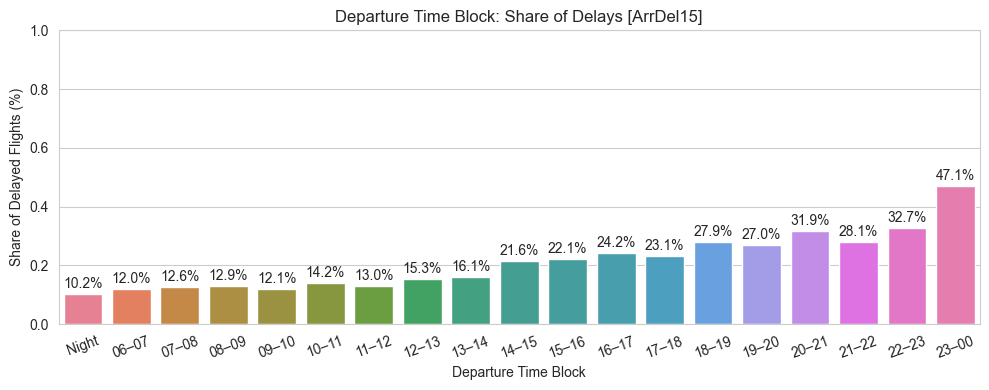

In [13]:
DepTimeBlk_delay_rate = np.round(df.groupby("DepTimeBlk")['ArrDel15'].mean().reset_index(), 3)


def dep_time_blk_to_label_24(x):
    if pd.isna(x):
        return np.nan

    start = str(x).split("-")[0]
    hh = int(start[:2])
    return f"{hh:02d}–{(hh + 1) % 24:02d}"


DepTimeBlk_delay_rate["DepTimeBlk"] = DepTimeBlk_delay_rate["DepTimeBlk"].apply(dep_time_blk_to_label_24)
DepTimeBlk_delay_rate["DepTimeBlk"] = DepTimeBlk_delay_rate["DepTimeBlk"].replace({"00–01": "Night"})

plt.figure(figsize=(10, 4))

ax = sns.barplot(data=DepTimeBlk_delay_rate, x="DepTimeBlk", y="ArrDel15", hue="DepTimeBlk", legend=False)
plt.title("Departure Time Block: Share of Delays [ArrDel15]")
plt.xlabel("Departure Time Block")
plt.xticks(rotation=20)
plt.ylabel("Share of Delayed Flights (%)")
plt.ylim([0, 1])
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h*100:.1f}%",
        xy=(p.get_x() + p.get_width() / 2, h+0.01),
        ha='center',
        va="bottom",
    )
plt.tight_layout()
plt.savefig("img/EDA/DepTimeBlk_delay_rate.png", dpi=300, bbox_inches="tight")
plt.show()

## HourlyWeatherType

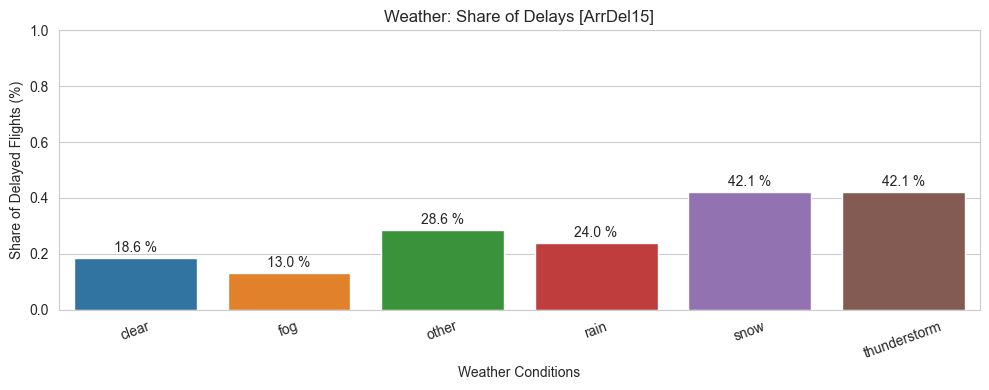

In [14]:
WeatherType_delay_rate = np.round(df.groupby("HourlyWeatherType")['ArrDel15'].mean().reset_index(), 3)

plt.figure(figsize=(10, 4))

ax = sns.barplot(data=WeatherType_delay_rate, x="HourlyWeatherType", y="ArrDel15", hue="HourlyWeatherType", legend=False)
plt.title("Weather: Share of Delays [ArrDel15]")
plt.xlabel("Weather Conditions")
plt.xticks(rotation=20)
plt.ylabel("Share of Delayed Flights (%)")
plt.ylim([0, 1])
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h*100:.1f} %",
        xy=(p.get_x() + p.get_width() / 2, h+0.01),
        ha='center',
        va="bottom",
    )
plt.tight_layout()
plt.savefig("img/EDA/HourlyWeatherType_delay_rate.png", dpi=300, bbox_inches="tight")
plt.show()

---

# Regression Analysis

---

In [15]:
df = pd.read_csv('data/ready_df_with_dep.csv')
df.head()

,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,DepDelay,DepDel15,DepTimeBlk,...,dep_time_shift_sin,dep_time_shift_cos,is_night_departure,is_evening_departure,low_visibility,strong_wind,wind_gust,bad_weather_score,is_hub_route,is_roundtrip
0,1,1,1,1,AA,SDF,MIA,0.0,0.0,0001-0559,...,0.000000,0.000000,0,0,0,0,0,0,0,1
1,1,1,1,1,NK,SDF,LAS,-7.0,0.0,0600-0659,...,-0.000466,0.030539,0,0,0,0,0,0,0,1
2,1,1,1,1,DL,SDF,ATL,-4.0,0.0,0600-0659,...,-0.000152,0.017452,0,0,0,0,0,0,1,1
3,1,1,1,1,WN,SDF,MCO,-4.0,0.0,0600-0659,...,0.000228,0.017452,0,0,0,0,0,0,0,1
4,1,1,1,1,AA,SDF,CLT,18.0,1.0,0600-0659,...,-0.009229,-0.077975,0,0,0,0,0,0,1,1


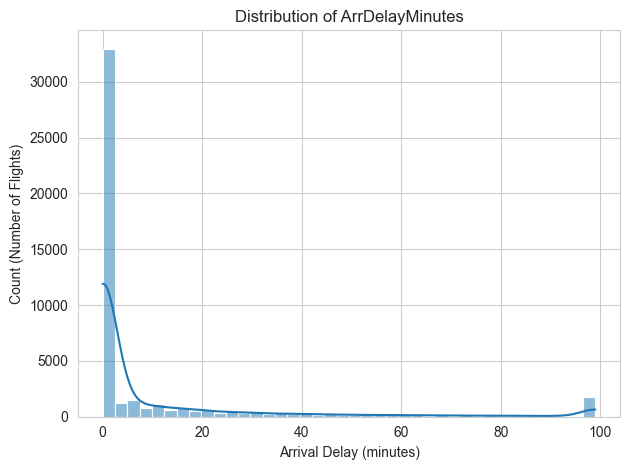

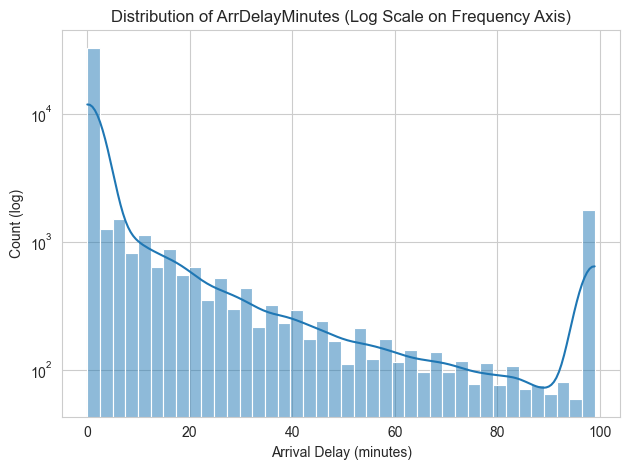

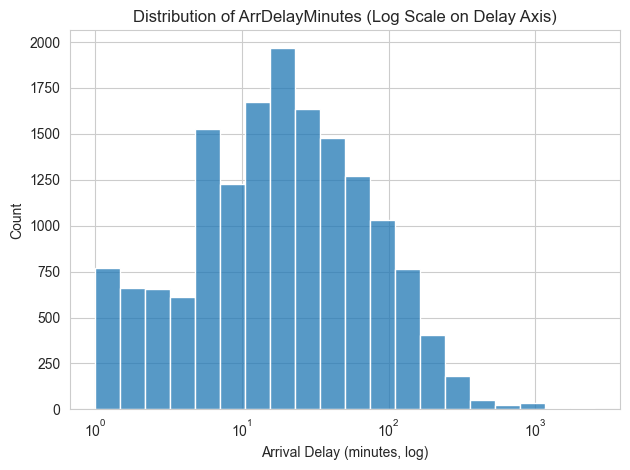

In [17]:
ax = sns.histplot(data=df['ArrDelayMinutes'].clip(lower=0, upper=99), kde=True, bins=40)
plt.title("Distribution of ArrDelayMinutes")
plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Count (Number of Flights)")
plt.tight_layout()
plt.savefig("img/EDA/r_ArrDelayMinutes_hist.png", dpi=300, bbox_inches="tight")
plt.show()
#---------------------------------------------------------------------------------
ax = sns.histplot(data=df['ArrDelayMinutes'].clip(lower=0, upper=99), kde=True, bins=40)
plt.yscale('log')
plt.title("Distribution of ArrDelayMinutes (Log Scale on Frequency Axis)")
plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Count (log)")
plt.tight_layout()
plt.savefig("img/EDA/r_ArrDelayMinutes_hist_log.png", dpi=300, bbox_inches="tight")
plt.show()
#---------------------------------------------------------------------------------
ax = sns.histplot(data=df['ArrDelayMinutes'], bins=20, log_scale=True)
plt.title("Distribution of ArrDelayMinutes (Log Scale on Delay Axis)")
plt.xlabel("Arrival Delay (minutes, log)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("img/EDA/r_ArrDelayMinutes_hist_log_delay.png", dpi=300, bbox_inches="tight")
plt.show()

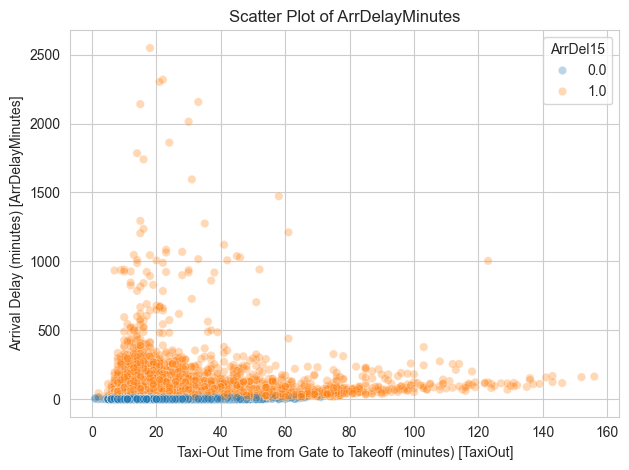

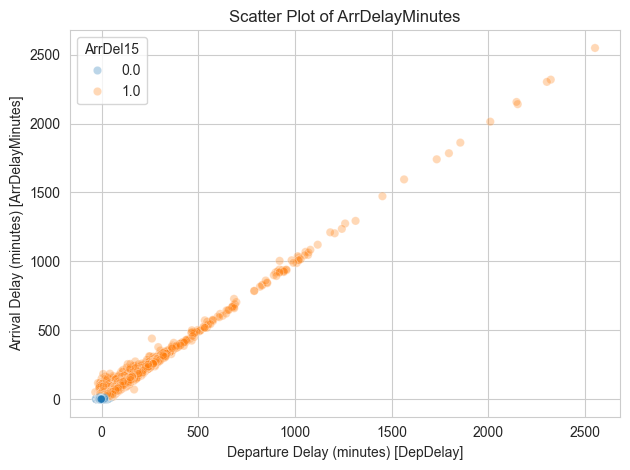

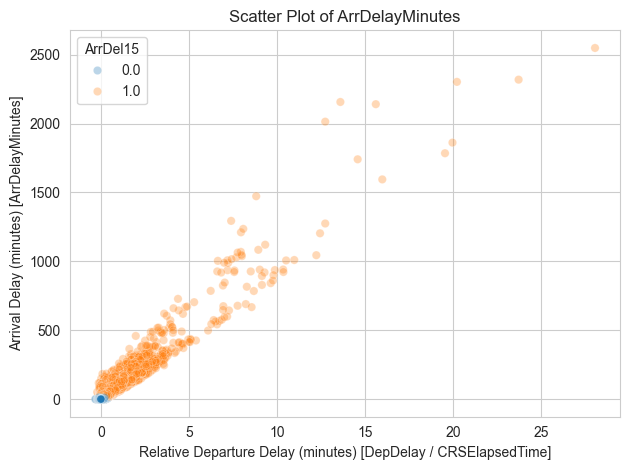

In [18]:
sns.scatterplot(data=df, x="TaxiOut", y="ArrDelayMinutes", alpha=0.3, hue="ArrDel15")
plt.title("Scatter Plot of ArrDelayMinutes")
plt.xlabel("Taxi-Out Time from Gate to Takeoff (minutes) [TaxiOut]")
plt.ylabel("Arrival Delay (minutes) [ArrDelayMinutes]")
plt.tight_layout()
plt.savefig("img/EDA/r_TaxiOut_scatter_delay.png", dpi=300, bbox_inches="tight")
plt.show()
#---------------------------------------------------------------------------------
sns.scatterplot(data=df, x="DepDelay", y="ArrDelayMinutes", alpha=0.3, hue="ArrDel15")
plt.title("Scatter Plot of ArrDelayMinutes")
plt.xlabel("Departure Delay (minutes) [DepDelay]")
plt.ylabel("Arrival Delay (minutes) [ArrDelayMinutes]")
plt.tight_layout()
plt.savefig("img/EDA/r_DepDelay_scatter_delay.png", dpi=300, bbox_inches="tight")
plt.show()
#---------------------------------------------------------------------------------
sns.scatterplot(data=df, x="dep_delay_ratio", y="ArrDelayMinutes", alpha=0.3, hue="ArrDel15")
plt.title("Scatter Plot of ArrDelayMinutes")
plt.xlabel("Relative Departure Delay (minutes) [DepDelay / CRSElapsedTime]")
plt.ylabel("Arrival Delay (minutes) [ArrDelayMinutes]")
plt.tight_layout()
plt.savefig("img/EDA/r_DepDelayRatio_scatter_delay.png", dpi=300, bbox_inches="tight")
plt.show()
